# Visual Invertibility of Activation Maps

In [1]:
from pathlib import Path
import random
import matplotlib.pyplot as plt
# plt.style.use('dark_background')
plt.style.use('default')

import h5py
import numpy as np
import tenseal as ts
import torch
import torch.nn as nn
from icecream import ic
ic.configureOutput(includeContext=True)

print(f'torch version: {torch.__version__}')
print(f'tenseal version: {ts.__version__}')

project_path = Path.cwd().parent
print(f'project_path: {project_path}')

torch version: 1.8.1+cu102
tenseal version: 0.3.5
project_path: /home/dk/Desktop/split-learning-1D-HE


## Data

In [2]:
with h5py.File(project_path/'data/train_ecg.hdf5', 'r') as hdf:
    x = hdf['x_train'][:]
    y = hdf['y_train'][:]

In [3]:
x_list = [list() for i in range(5)]
y_list = ['N', 'L', 'R', 'A', 'V']

In [4]:
for i in range(len(x_list)):
    idx = np.where(y == i)
    x_list[i] = x[idx]
    print(x_list[i].shape)

(3000, 1, 128)
(3000, 1, 128)
(3000, 1, 128)
(1245, 1, 128)
(3000, 1, 128)


In [5]:
def pick_for_each_class(x_list):
    return_list = []
    for i in range(len(x_list)):
        return_list.append(random.choice(x_list[i]))
    return return_list
random_signals = pick_for_each_class(x_list)

## Plotting Original Signals

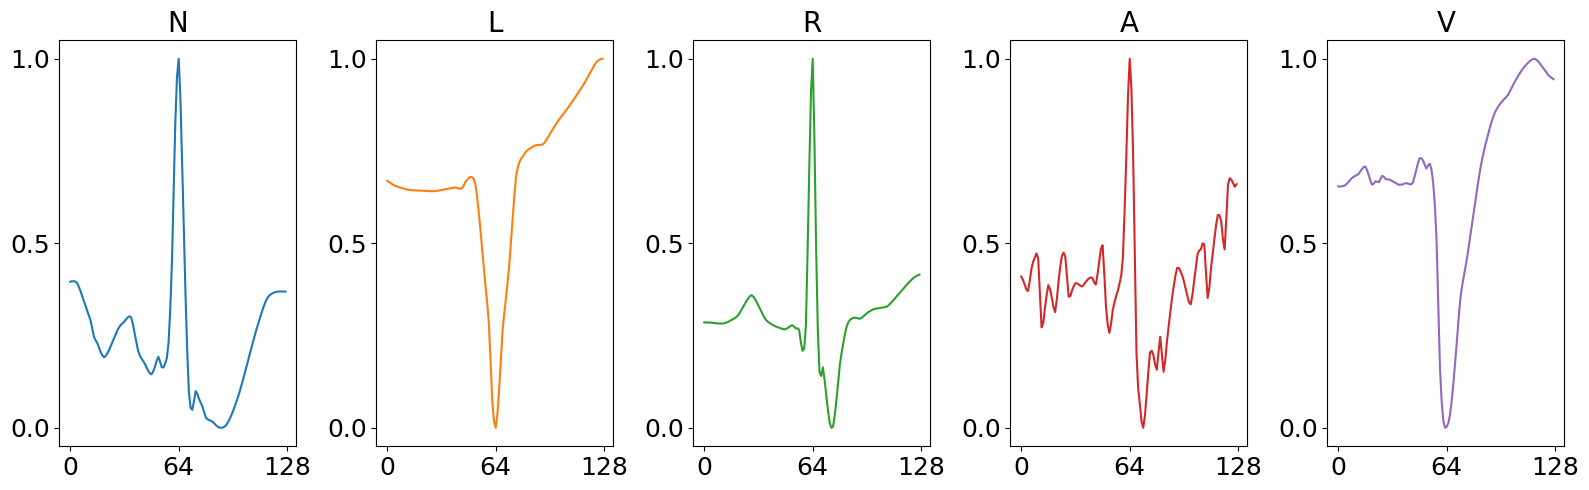

In [6]:
fig, ax = plt.subplots(1, 5, figsize=(16, 5))
for i in range(len(random_signals)):
    ax[i].set_title(y_list[i], size=20)
    ax[i].tick_params(labelsize=18)
    r = random_signals[i].squeeze() # normalize
    r = (r - min(r)) / (max(r) - min(r))
    ax[i].plot(r, color='C'+str(i))
    ax[i].set_xticks([0, 64, 128])
    ax[i].set_yticks([0, 0.5, 1.0])
fig.tight_layout()

## Model

In [7]:
class ECGConv1D(nn.Module):
    def __init__(self):
        super(ECGConv1D, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=1, 
                               out_channels=16, 
                               kernel_size=7, 
                               padding=3,
                               stride=1)  # 128 x 16
        self.relu1 = nn.LeakyReLU()
        self.pool1 = nn.MaxPool1d(2)  # 64 x 16
        self.conv2 = nn.Conv1d(in_channels=16, 
                               out_channels=8, 
                               kernel_size=5, 
                               padding=2)  # 64 x 8
        self.relu2 = nn.LeakyReLU()
        self.pool2 = nn.MaxPool1d(2)  # 32 x 8 = 256
        
        self.linear = nn.Linear(256, 5)
        self.softmax = nn.Softmax(dim=1)
    
    def forward(self, x):
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.pool1(x)
        x = self.conv2(x)
        x = self.relu2(x)
        x = self.pool2(x)

        return x.data.numpy().squeeze()

In [9]:
model = ECGConv1D()
model.load_state_dict(torch.load(project_path/'weights/trained_weight_256.pth'))
model.eval()

ECGConv1D(
  (conv1): Conv1d(1, 16, kernel_size=(7,), stride=(1,), padding=(3,))
  (relu1): LeakyReLU(negative_slope=0.01)
  (pool1): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv1d(16, 8, kernel_size=(5,), stride=(1,), padding=(2,))
  (relu2): LeakyReLU(negative_slope=0.01)
  (pool2): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (linear): Linear(in_features=256, out_features=5, bias=True)
  (softmax): Softmax(dim=1)
)

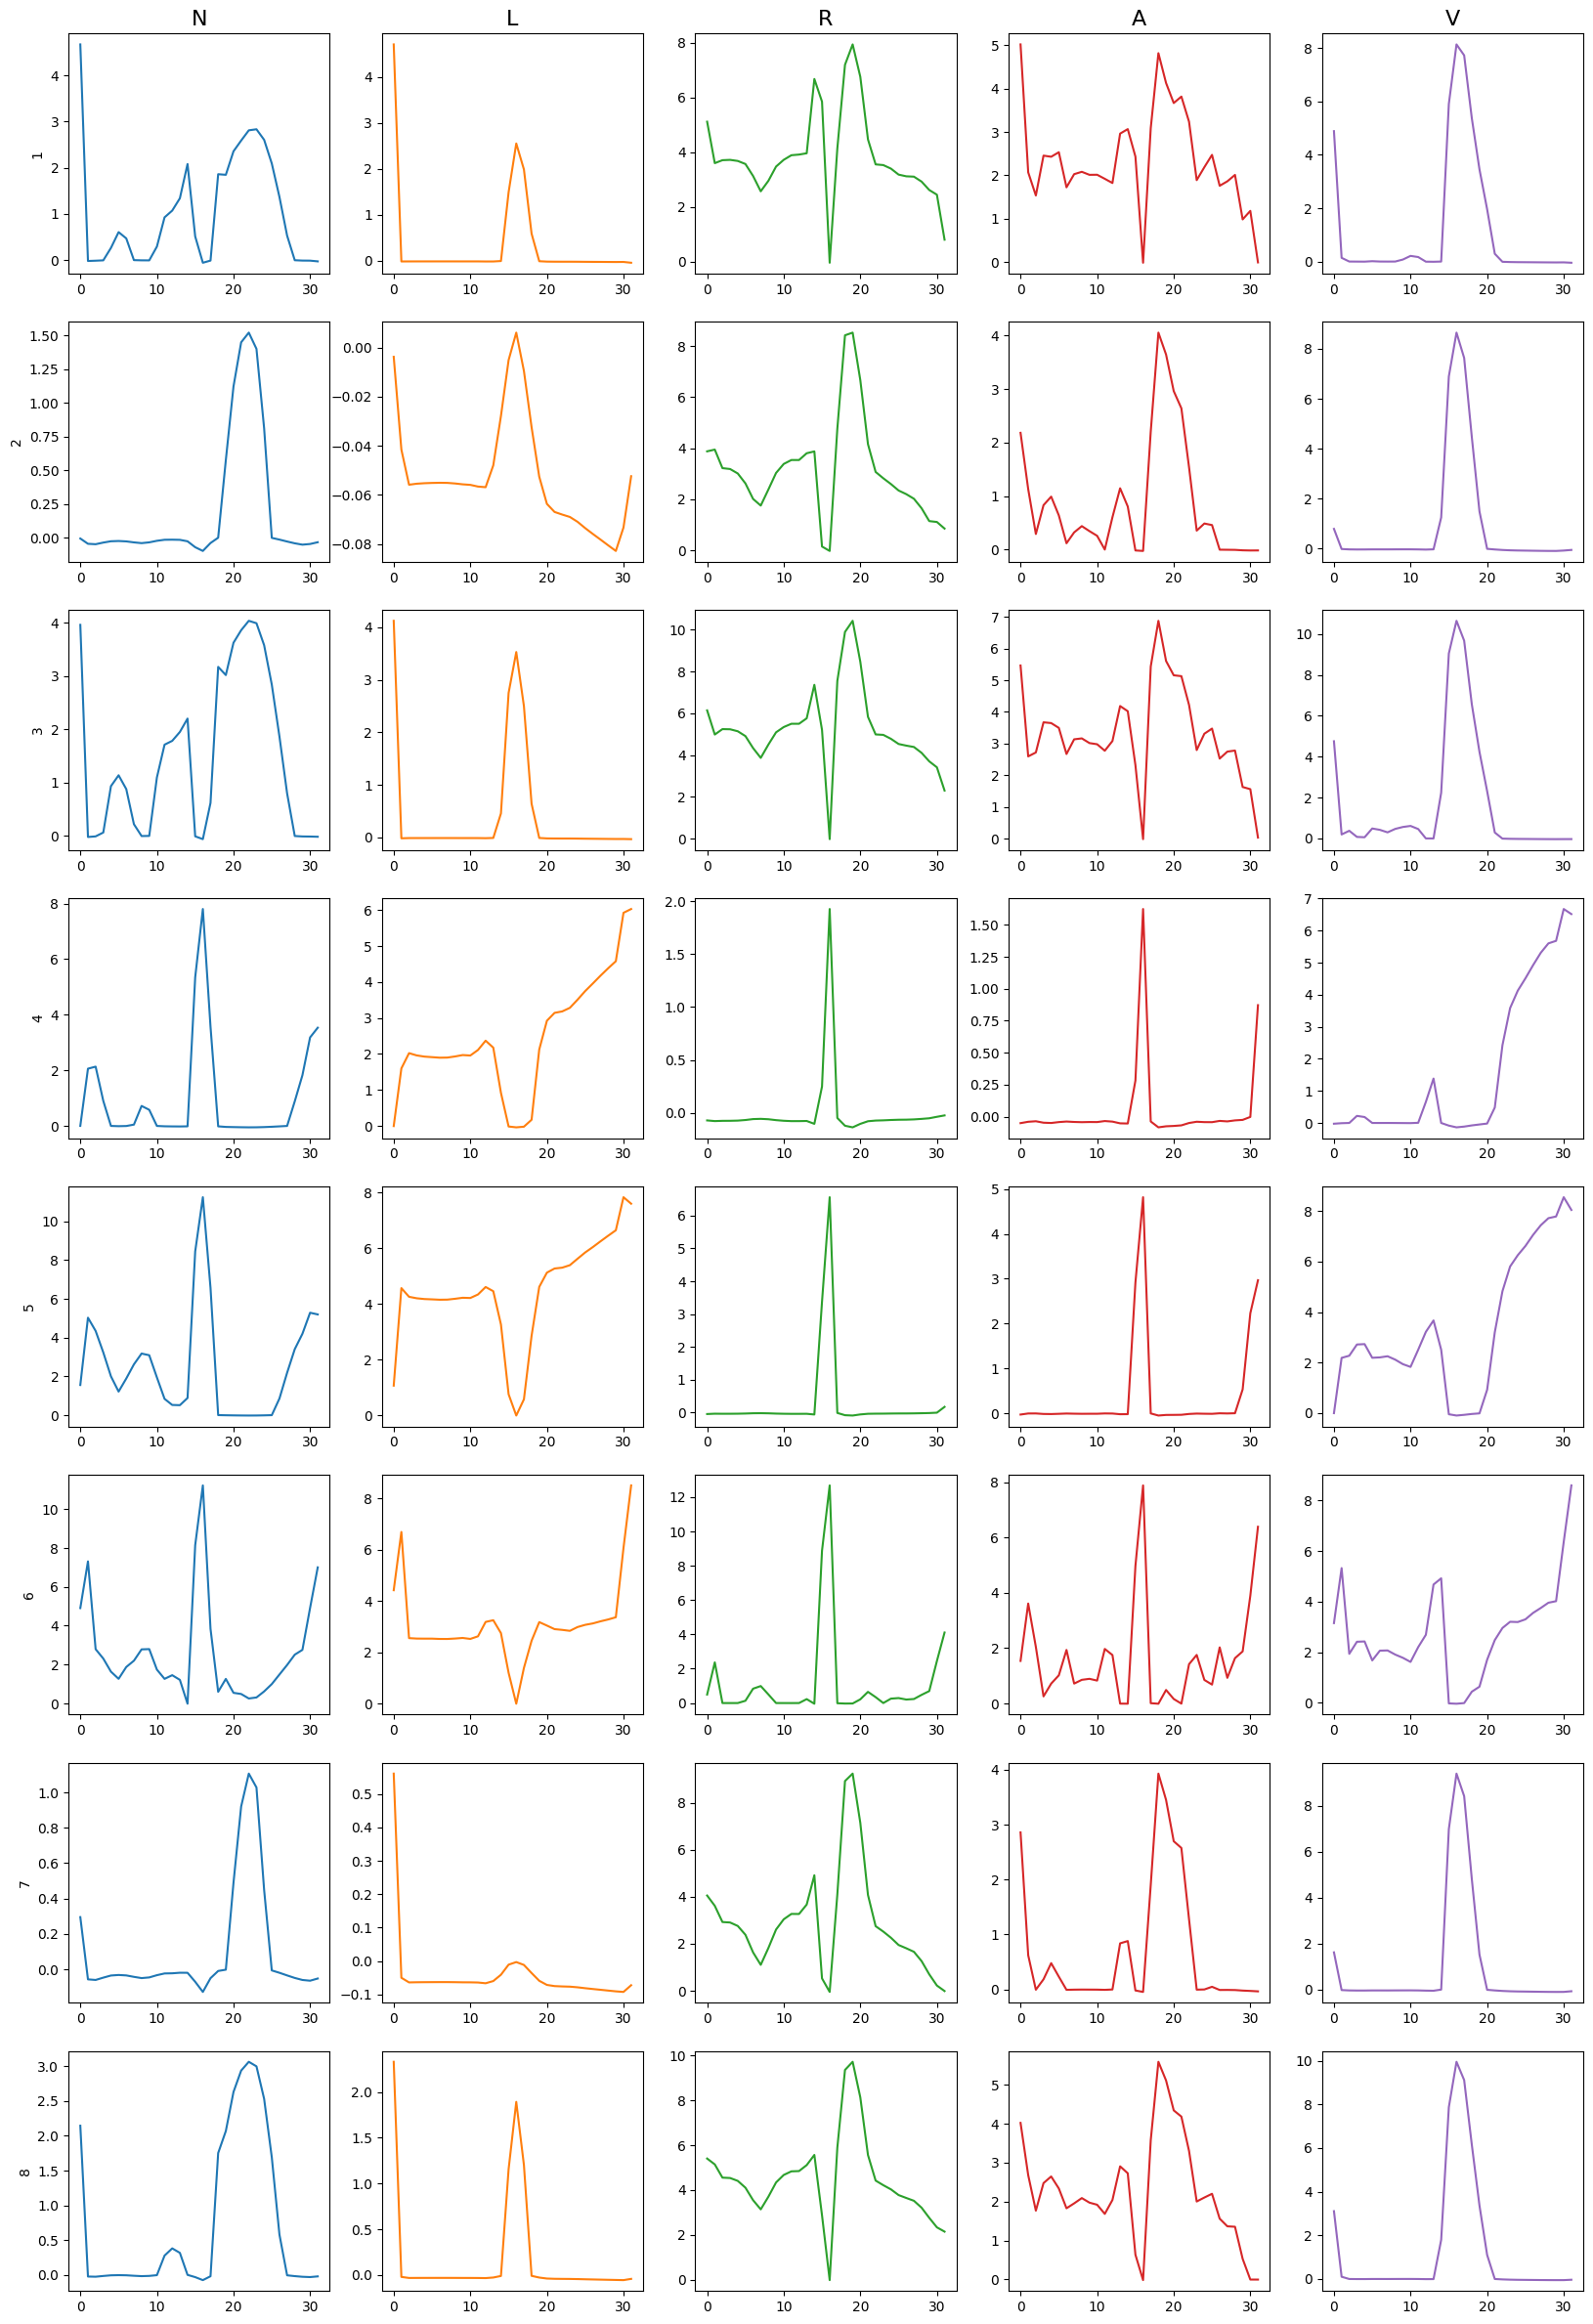

In [10]:
fig, ax = plt.subplots(8, 5, figsize=(20, 30))
for i in range(len(x_list)):
    x = torch.tensor(np.expand_dims(random_signals[i], axis=0), 
                     dtype=torch.float,
                     requires_grad=False)
    output = model(x)
    for j in range(len(output)):
        if j == 0:
            ax[j][i].set_title(y_list[i], size=16)
        if i == 0:
            ax[j][i].set_ylabel(str(j+1))
        ax[j][i].plot(output[j], color='C'+str(i))

## Most similar activations

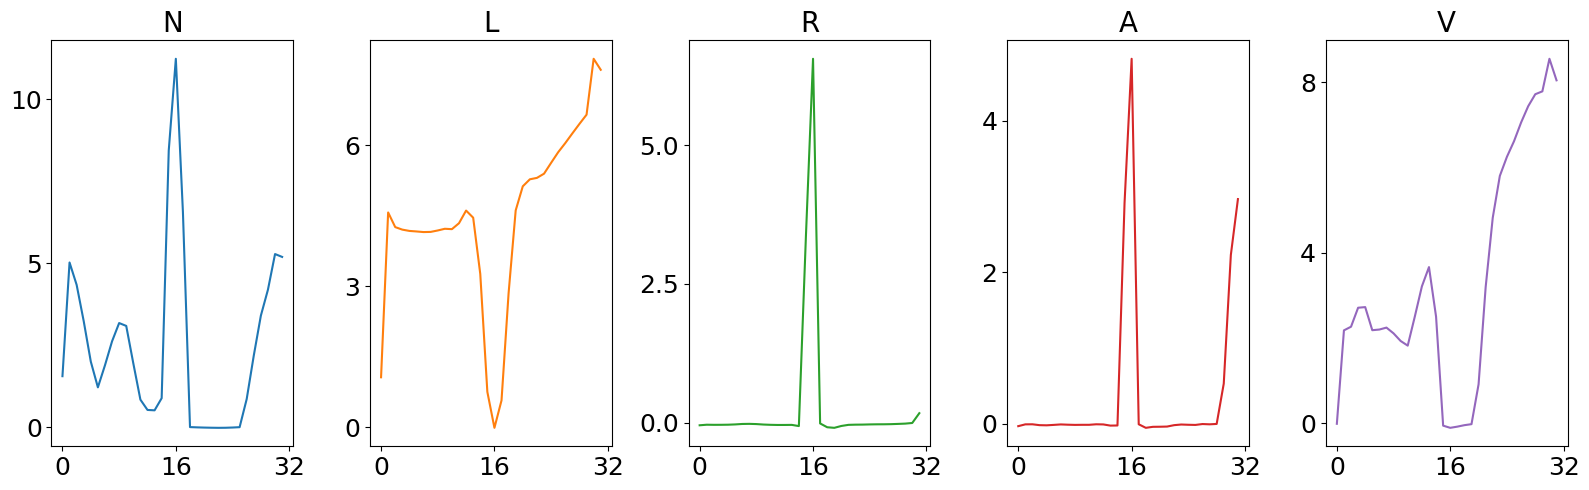

In [11]:
fig, ax = plt.subplots(1, 5, figsize=(16, 5))
for i in range(len(x_list)):
    x = torch.tensor(np.expand_dims(random_signals[i], axis=0), 
                     dtype=torch.float,
                     requires_grad=False)
    output = model(x)
    ax[i].set_title(y_list[i], size=20)
    ax[i].plot(output[4], color='C'+str(i)) # filter 14
    ax[i].tick_params(labelsize=18)
    ax[i].yaxis.set_major_locator(plt.MaxNLocator(3))
    ax[i].set_xticks([0, 16, 32])
fig.tight_layout()